# Single queue simulation

This notebook provides a simple, single queue simulation. We generate jobs, run them through the system and compare the behavior to Little's Law for verification.

The goal is to develop intuitions about the underlying dynamics of the system, especially around inputs, outputs, and how queueing processes convert inputs into outputs. On the input side we want to understand how to reduce response times to queueing parameters. On the output side we want to understand the performance metrics available and how we can measure them.

**Reduction of response times to queueing parameters.** First we show how to reduce response times to the following queueing network parameters:

- mean arrival rate
- mean service rate

Eventually we will also incorporate

- job scheduling policy: policy around how we prioritize waiting jobs; and
- job assignment policy: policy around how we assign jobs to resources

though this notebook simply assumes First-Come-First-Served (FCFS) scheduling, and assumes a single resource (which makes assignment not applicable).

**Performance measurement.** We show how to measure the following performance metrics:

- response time
- number of jobs in the system
- wait time
- device utilization
- throughput

**Little's Law** for open systems is

$$ {\mathbb E}[N] = \lambda {\mathbb E}[T] $$

where

- $\lambda$ = mean job arrival rate
- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)
- ${\mathbb E}$ is the expectation operator

## 0 Setup 

In [153]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.display import Markdown

In [154]:
TITLE_SIZE = 18
HIST_BINS = 21

rng = np.random.default_rng(42)

## 1 Simulation 

In [155]:
# lambda = mean_arrival_rate
# mu = mean_service_rate
def run_sim_and_plot(n, mean_arrival_rate, mean_service_rate):
    params = build_params(n, mean_arrival_rate, mean_service_rate)
    display(Markdown(
        f"### Simulation: n={n}, " +
        f"$\lambda$={params['mean_arrival_rate']:,.4f}, " +
        f"$\mu$={params['mean_service_rate']:,.4f}, " +
        f"$1/\lambda$={params['mean_interarrival_time']:,.4f}, " +
        f"$1/\mu$={params['mean_service_time']:,.4f}"
    ))
    result = run_sim(params)
    dump_stats(result)
    plot_result(result)

def build_params(num_jobs, mean_arrival_rate, mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "mean_service_rate": mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
        "num_bins": int(num_jobs / mean_arrival_rate)
    }
    
def run_sim(params):
    n = params["n"]
    
    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    mean_service_time = params["mean_service_time"]
    
    # Simulation data and results
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    arrival_times = np.cumsum(interarrival_times)
    service_times = rng.exponential(scale=mean_service_time, size=n)
    jobs_df = build_jobs_df(params, interarrival_times, arrival_times, service_times)
    intervals_df = build_intervals_df(params, jobs_df)
    total_width = intervals_df.iloc[-1]["up_bd"]
    
#    display(intervals_df.head(40))
    
    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_mean_response_time = jobs_df["response_time"].mean()
    
    # mean_num_jobs_in_system and mean_num_jobs_in_queue
    total_weighted_num_jobs_in_system = intervals_df["weighted_num_jobs_in_system"].sum()
    total_weighted_num_jobs_in_queue = intervals_df["weighted_num_jobs_in_queue"].sum()
    total_width = intervals_df.iloc[-1]["up_bd"]
    sim_mean_num_jobs_in_system = total_weighted_num_jobs_in_system / total_width
    sim_mean_num_jobs_in_queue = total_weighted_num_jobs_in_queue / total_width
    
    # mean_throughput
    # FIXME
#    completions = intervals_df.loc[intervals_df["num_jobs_change"] == -1.0, "up_bd"]
#    hist, _ = np.histogram(completions, bins=int(total_width))
#    sim_mean_throughput = np.mean(hist)

    # utilization
    busy_width = intervals_df.loc[intervals_df["busy"] == True, "width"].sum()
    util = busy_width / total_width
    
    # TODO Estimate response time variance
    return {
        "params": params,
        "jobs_df": jobs_df,
        "intervals_df": intervals_df,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "mean_response_time": sim_mean_response_time,
        "mean_num_jobs_in_system": sim_mean_num_jobs_in_system,
        "mean_num_jobs_in_queue": sim_mean_num_jobs_in_queue,
#        "mean_throughput": sim_mean_throughput,
        "utilization": util,
    }

def build_jobs_df(params, interarrival_times, arrival_times, service_times):    
    n = params["n"]
    
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })
    
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    for i in range(1, n):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df

# Build intervals and their corresponding N (number of jobs in system) and
# N_Q (number of jobs in queue). This will allow us to visualize job count
# behavior and estimate E[N] and E[N_Q].
def build_intervals_df(params, jobs_df):
    n = params["n"]
    arrivals = jobs_df["arrive_time"]
    starts = jobs_df["start_time"]
    departures = jobs_df["depart_time"]
    
    intervals_df = pd.DataFrame(columns=["lo_bd", "up_bd", "width", "num_jobs_in_system", "num_jobs_in_queue"])

    lo_bd = 0.0
    arrive_idx = 0
    start_idx = 0
    depart_idx = 0
    curr_busy = False
    num_jobs_in_system = 0
    num_jobs_in_queue = 0
    
    while depart_idx < n:
        arrival = arrivals[arrive_idx] if arrive_idx < n else 10000000000.0
        start = starts[start_idx] if start_idx < n else 10000000000.0
        departure = departures[depart_idx]
        
        num_jobs_in_system_orig = num_jobs_in_system
        num_jobs_in_queue_orig = num_jobs_in_queue
                
        if arrival <= start and arrival <= departure: # new arrival
            next_busy = curr_busy
            num_jobs_in_system = num_jobs_in_system + 1
            num_jobs_in_queue = num_jobs_in_queue + 1
            up_bd = arrival
            arrive_idx = arrive_idx + 1        
        elif start <= arrival and start <= departure: # new start
            next_busy = True
            num_jobs_in_queue = num_jobs_in_queue - 1
            up_bd = start
            start_idx = start_idx + 1
        elif departure <= arrival and departure <= start: # new departure
            next_busy = False
            num_jobs_in_system = num_jobs_in_system - 1
            up_bd = departure
            depart_idx = depart_idx + 1
        else:
            print("unhandled case, not expected!")

        width = up_bd - lo_bd
        intervals_df = intervals_df.append({
            "lo_bd": lo_bd,
            "up_bd": up_bd,
            "width": width,
            "busy": curr_busy,
            "num_jobs_in_system": num_jobs_in_system,
            "num_jobs_in_queue": num_jobs_in_queue,
            "num_jobs_in_system_change": num_jobs_in_system - num_jobs_in_system_orig,
            "num_jobs_in_queue_change": num_jobs_in_queue - num_jobs_in_queue_orig,
            "weighted_num_jobs_in_system": width * num_jobs_in_system,
            "weighted_num_jobs_in_queue": width * num_jobs_in_queue,
        }, ignore_index=True)

        lo_bd = up_bd
        curr_busy = next_busy
    
    return intervals_df

In [156]:
# STATS DUMPS

def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    intervals_df = result["intervals_df"]
    mean_arrival_rate = result["mean_arrival_rate"]
    mean_response_time = result["mean_response_time"]
    
    print("Simulation statistics")
    print("---------------------")
    print(f"mean_arrival_rate       = {mean_arrival_rate:,.4f}")
    print(f"mean_interarrival_time  = {result['mean_interarrival_time']:,.4f}")
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print(f"mean_response_time      = {mean_response_time:,.4f}")
    print(f"mean_wait_time          = {result['mean_wait_time']:,.4f}")
    print(f"mean_service_time       = {result['mean_service_time']:,.4f}")
    print(f"mean_num_jobs_in_system = {result['mean_num_jobs_in_system']:,.4f}")
    print(f"mean_num_jobs_in_queue  = {result['mean_num_jobs_in_queue']:,.4f}")
#    print(f"mean_throughput         = {result['mean_throughput']:,.4f}")
    print(f"utilization             = {result['utilization']:,.4f}")
    print("")
    print("Little's Law: E[N] = lambda * E[T]")
    print("----------------------------------")
    print(f"mean_num_jobs_in_system                = {result['mean_num_jobs_in_system']:,.4f}")
    print(f"mean_arrival_rate * mean_response_time = {mean_arrival_rate * mean_response_time:,.4f}" +
         f" (= {mean_arrival_rate:,.4f} * {mean_response_time:,.4f})")

In [157]:
# PLOTTING FUNCTIONS

def plot_result(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    intervals_df = result["intervals_df"]
    
    _plot_histogram(params, jobs_df["interarrival_time"], "Histogram of interarrival times", "Interarrival time")
    _plot_histogram(params, jobs_df["arrive_time"], "Histogram of arrival times", "Arrival time")
    _plot_histogram(params, jobs_df["wait_time"], "Histogram of wait times", "Wait time")
    _plot_histogram(params, jobs_df["service_time"], "Histogram of service times", "Service time")
    _plot_histogram(params, jobs_df["response_time"], "Histogram of response times", "Response time")
    _plot_jobs_gantt(params, jobs_df)    
    _plot_jobs_over_time(intervals_df)    

def _plot_histogram(params, data, title, xlabel):
    plt.figure(figsize=(14, 2))
    plt.title(title, size=TITLE_SIZE)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.hist(data, bins=HIST_BINS)
    plt.show()

def _plot_jobs_gantt(params, jobs_df):
    n = params["n"]
    start_job = int(n / 2)
    end_job = start_job + 40
    trunc_df = jobs_df[start_job:end_job]
    
    plt.figure(figsize=(14, 8))
    plt.title("Job schedule (partial view)", size=TITLE_SIZE)
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["arrive_time"],
        width=trunc_df["response_time"],
        alpha=1.0,
        color="gainsboro")
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["start_time"],
        width=trunc_df["service_time"],
        alpha=1.0,
        color="limegreen")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()

def _plot_jobs_over_time(intervals_df):
    plt.figure(figsize=(14, 2))
    plt.title("# jobs in system over time", size=TITLE_SIZE)
    plt.xlabel("Time")
    plt.ylabel("Job count")
    plt.plot(intervals_df["lo_bd"], intervals_df["num_jobs_in_system"])
    plt.show()

## 2 Simulation runs 

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=64.0000, $1/\lambda$=0.0625, $1/\mu$=0.0156

Simulation statistics
---------------------
mean_arrival_rate       = 15.9990
mean_interarrival_time  = 0.0625
mean_response_time      = 0.0200
mean_wait_time          = 0.0049
mean_service_time       = 0.0151
mean_num_jobs_in_system = 0.9731
mean_num_jobs_in_queue  = 0.8335
utilization             = 0.1870

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs_in_system                = 0.9731
mean_arrival_rate * mean_response_time = 0.3204 (= 15.9990 * 0.0200)


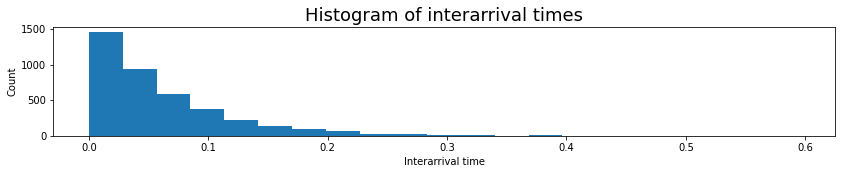

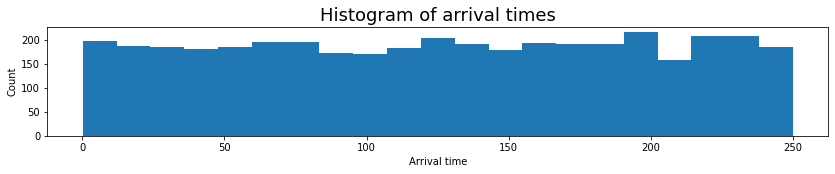

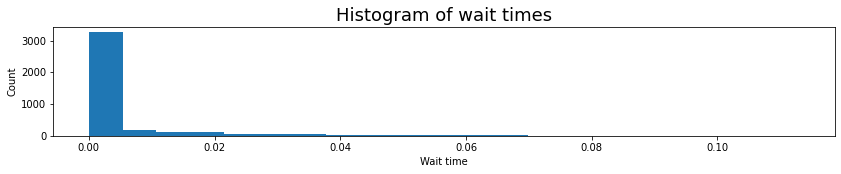

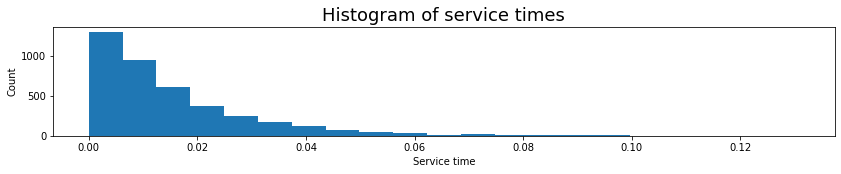

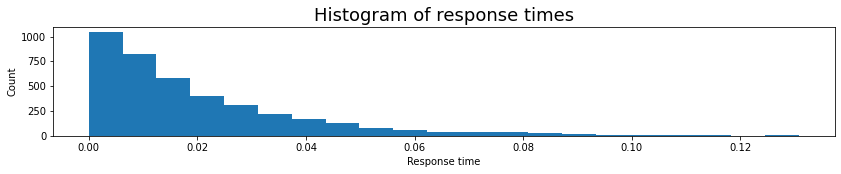

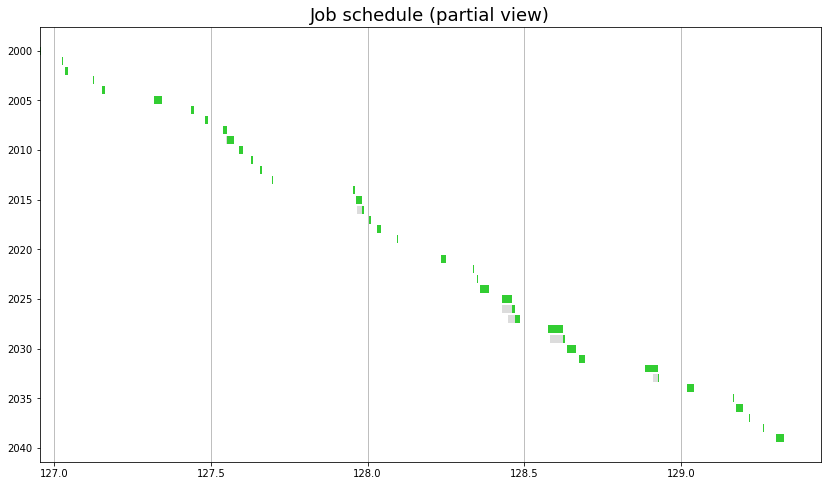

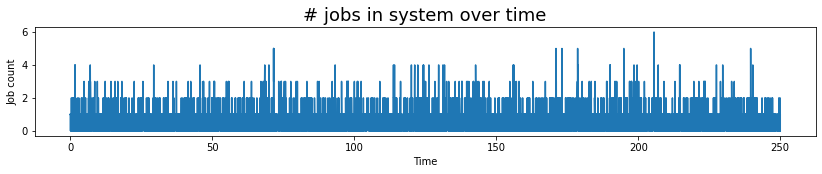

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=32.0000, $1/\lambda$=0.0625, $1/\mu$=0.0312

Simulation statistics
---------------------
mean_arrival_rate       = 15.7136
mean_interarrival_time  = 0.0636
mean_response_time      = 0.0646
mean_wait_time          = 0.0331
mean_service_time       = 0.0315
mean_num_jobs_in_system = 1.5125
mean_num_jobs_in_queue  = 1.0238
utilization             = 0.2533

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs_in_system                = 1.5125
mean_arrival_rate * mean_response_time = 1.0155 (= 15.7136 * 0.0646)


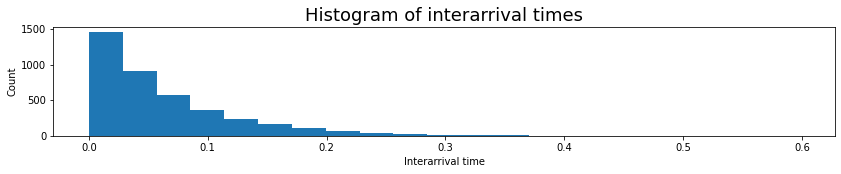

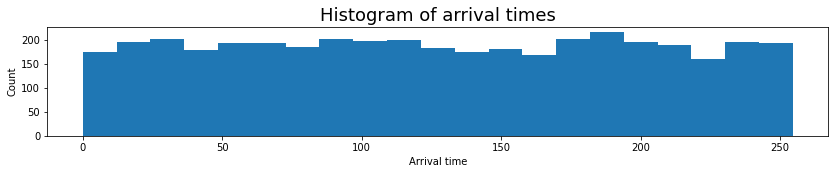

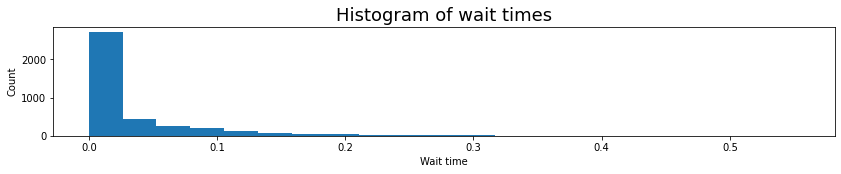

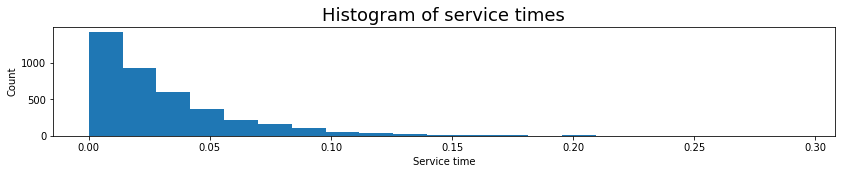

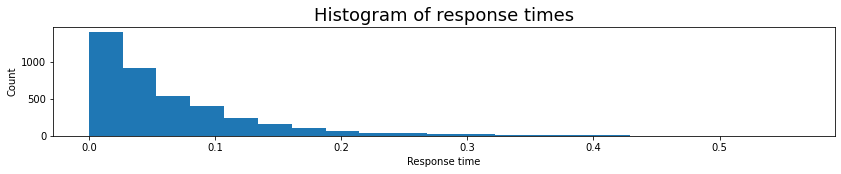

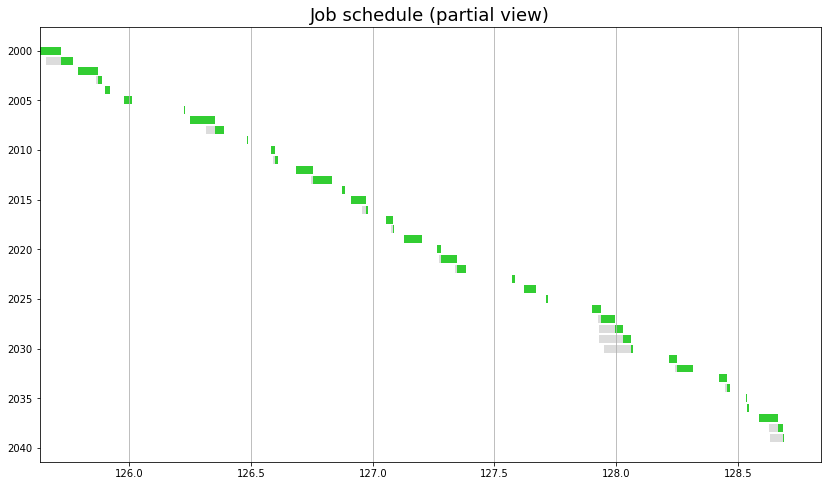

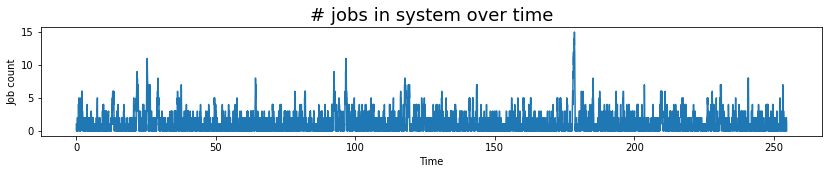

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=18.0000, $1/\lambda$=0.0625, $1/\mu$=0.0556

Simulation statistics
---------------------
mean_arrival_rate       = 16.1498
mean_interarrival_time  = 0.0619
mean_response_time      = 0.4744
mean_wait_time          = 0.4187
mean_service_time       = 0.0557
mean_num_jobs_in_system = 8.1383
mean_num_jobs_in_queue  = 6.8547
utilization             = 0.0963

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs_in_system                = 8.1383
mean_arrival_rate * mean_response_time = 7.6621 (= 16.1498 * 0.4744)


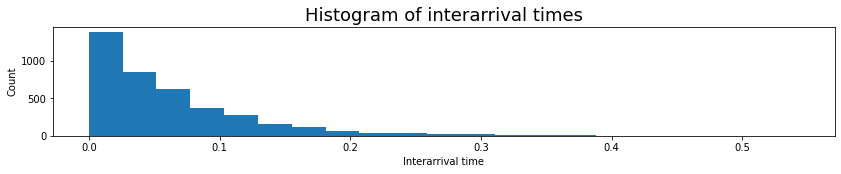

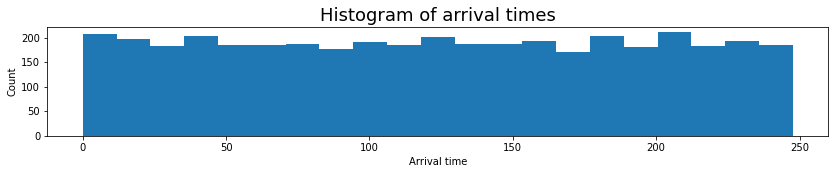

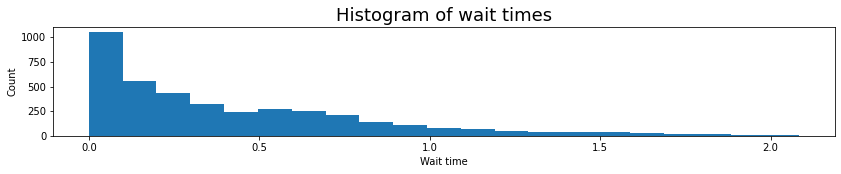

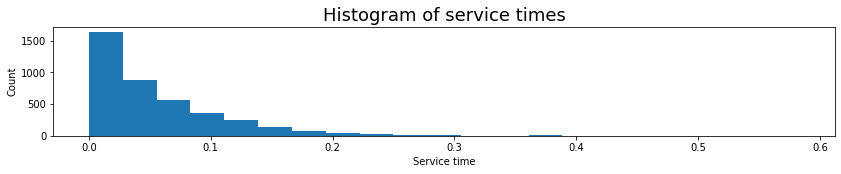

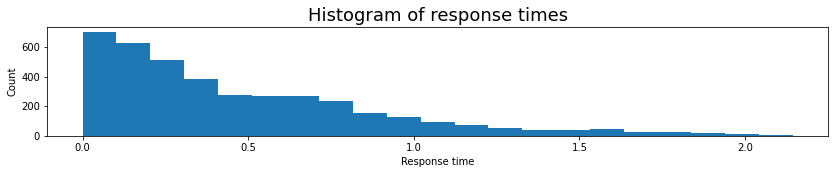

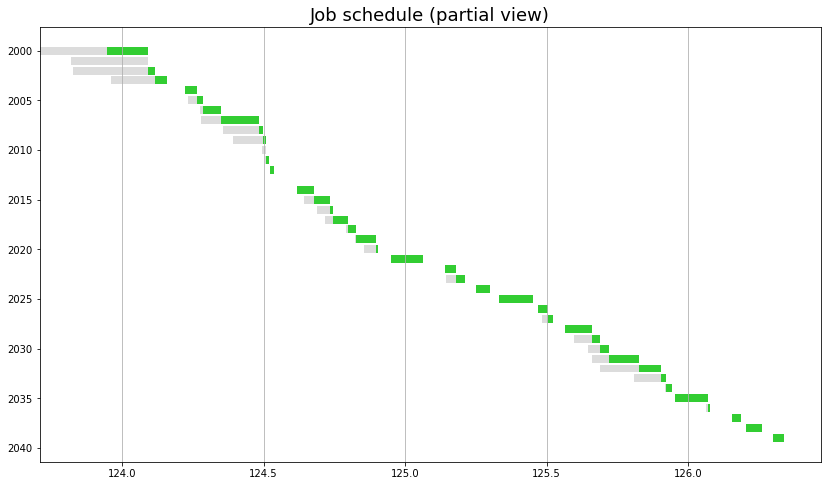

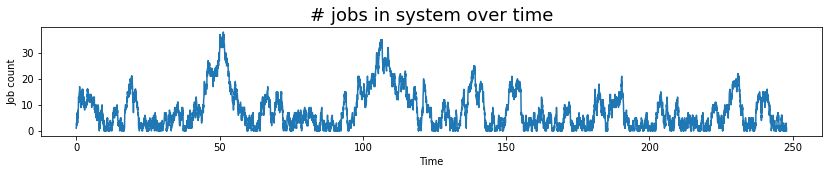

### Simulation: n=4000, $\lambda$=16.0000, $\mu$=16.0000, $1/\lambda$=0.0625, $1/\mu$=0.0625

KeyboardInterrupt: 

In [158]:
for mu in [64, 32, 18, 16, 15, 12]:
    run_sim_and_plot(4000, 16, mu)